In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from _src.kf import KalmanFilter
from _src.viz import plot_tracking_values
from jax import random

In [3]:
def sample_filter_smooth(lds_model, key):
    """
    Sample from a linear dynamical system, apply the kalman filter
    (forward pass), and performs smoothing.
    Parameters
    ----------
    lds: LinearDynamicalSystem
        Instance of a linear dynamical system with known parameters
    Returns
    -------
    Dictionary with the following key, values
    * (z_hist) array(timesteps, state_size):
        Simulation of Latent states
    * (x_hist) array(timesteps, observation_size):
        Simulation of observed states
    * (mu_hist) array(timesteps, state_size):
        Filtered means mut
    * (Sigma_hist) array(timesteps, state_size, state_size)
        Filtered covariances Sigmat
    * (mu_cond_hist) array(timesteps, state_size)
        Filtered conditional means mut|t-1
    * (Sigma_cond_hist) array(timesteps, state_size, state_size)
        Filtered conditional covariances Sigmat|t-1
    * (mu_hist_smooth) array(timesteps, state_size):
        Smoothed means mut
    * (Sigma_hist_smooth) array(timesteps, state_size, state_size)
        Smoothed covariances Sigmat
    """
    z_hist, x_hist = lds_model.sample(key)
    mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist = lds_model.filter(x_hist)
    mu_hist_smooth, Sigma_hist_smooth = lds_model.smooth(mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist)

    return {
        "z_hist": z_hist,
        "x_hist": x_hist,
        "mu_hist": mu_hist,
        "Sigma_hist": Sigma_hist,
        "mu_cond_hist": mu_cond_hist,
        "Sigma_cond_hist": Sigma_cond_hist,
        "mu_hist_smooth": mu_hist_smooth,
        "Sigma_hist_smooth": Sigma_hist_smooth
    }


In [4]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

key = random.PRNGKey(314)
timesteps = 15
Δ = 1.0
A = jnp.array([
    [1, 0, Δ, 0],
    [0, 1, 0, Δ],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
# Prior parameter distribution
mu0 = jnp.array([8, 10, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 1.0

lds_instance = KalmanFilter(A, C, Q, R, mu0, Sigma0, timesteps)


### Draw Samples

In [5]:
%%time
result = sample_filter_smooth(lds_instance, key)

CPU times: user 4.86 s, sys: 453 ms, total: 5.31 s
Wall time: 4.99 s


In [6]:
l2_filter = jnp.linalg.norm(result["z_hist"][:, :2] - result["mu_hist"][:, :2], 2)
l2_smooth = jnp.linalg.norm(result["z_hist"][:, :2] - result["mu_hist_smooth"][:, :2], 2)

print(f"L2-filter: {l2_filter:0.4f}")
print(f"L2-smooth: {l2_smooth:0.4f}")

L2-filter: 3.2481
L2-smooth: 2.0450


#### Viz

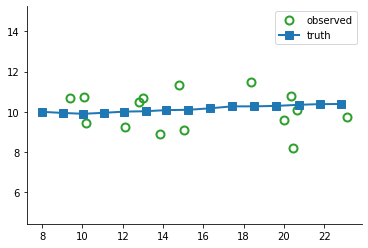

In [7]:
fig, axs = plt.subplots()
axs.plot(result["x_hist"][:, 0], result["x_hist"][:, 1], marker="o", linewidth=0,
     markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
axs.plot(result["z_hist"][:, 0], result["z_hist"][:, 1], linewidth=2, label="truth", marker="s", markersize=8)
axs.legend()
axs.axis("equal")
# pml.savefig("kalman_tracking_truth.png")
plt.show()

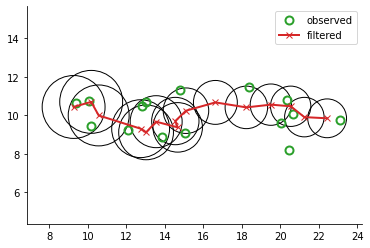

In [8]:
fig, axs = plt.subplots()
plot_tracking_values(result["x_hist"], result["mu_hist"], result["Sigma_hist"], "filtered", axs)
# pml.savefig("kalman_tracking_filtered.png")
plt.show()

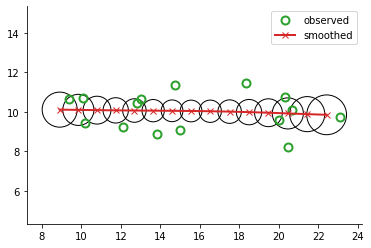

In [9]:
fig, axs = plt.subplots()
plot_tracking_values(result["x_hist"], result["mu_hist_smooth"], result["Sigma_hist_smooth"], "smoothed", axs)
# pml.savefig("kalman_tracking_smoothed.png")
plt.show()